<a href="https://colab.research.google.com/github/anna-dang/dsc-phase-4-project/blob/main/project_4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title
Describe data source, competition goal, etc. etc.

### Import libraries and download data

In [1]:
import os
from google.colab import drive

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/gdrive


In [2]:
# Mount Google Drive files, set up and navigate into OS working environment
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# Same as %cd /content/gdrive/My Drive/kaggle , make sure it works first
os.chdir(/content/gdrive/My Drive/kaggle)
os.getcwd()

/content/gdrive/My Drive/kaggle
kaggle.json


In [26]:
# Download dataset from Kaggle competition website
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:24<00:00, 96.4MB/s]
100% 2.29G/2.29G [00:24<00:00, 101MB/s] 


In [ ]:
# Unzip file and remove zip
#!unzip -q \*.zip  && rm *.zip

# Start here after a time out?

# Preprocessing

In [69]:
# Establish file paths for each of the folders
test_path = '/content/gdrive/My Drive/kaggle/chest_xray/test'
train_path = '/content/gdrive/My Drive/kaggle/chest_xray/train'
val_path = '/content/gdrive/My Drive/kaggle/chest_xray/val'

In [ ]:
#TODO visualize unprocessed image as example

In [91]:
# Set image size
img_size = (64, 64)

# Instantiate image generators with rescale set to reduce RBG values to between 0 and 1
rescale = (1./255)

# Data is already split into train/test/validation by source, format for Keras
print(" Train:")
train_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(
        train_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=5216) 

print("\n Test:")
test_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(
        test_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=624) 

print("\n Validation:")
val_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(
        val_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=16) 

 Train:
Found 5216 images belonging to 2 classes.

 Test:
Found 624 images belonging to 2 classes.

 Validation:
Found 16 images belonging to 2 classes.


In [ ]:
# Create the data sets from the generators, split features (images) from target (labels)
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [94]:
# Check that the data was generated properly
# Expect image size to be (quantity, set image size x size, 3) and labels (quantity,)
print("Train:", train_images.shape, train_labels.shape)
print("Test:", test_images.shape, test_labels.shape)
print("Val:", val_images.shape, val_labels.shape)

Train: (5216, 64, 64, 3) (5216,)
Test: (624, 64, 64, 3) (624,)
Val: (16, 64, 64, 3) (16,)


In [ ]:
# # ONLY IF USING A NON- CNN MODEL FIRST
# # reshape into single input vector of pixel values (check shape: quant, pix x pix x 3 rgb)
# train_img = train_images.reshape(train_images.shape[0], -1)
# test_img = test_images.reshape(test_images.shape[0], -1)
# val_img = val_images.reshape(val_images.shape[0], -1)

# EDA

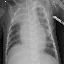

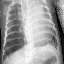

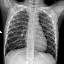

array([0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [105]:
# Preview some processed images and labels
[display(array_to_img(train_images[x])) for x in [10, 619, 1000]]
train_labels[100:125]

In [ ]:
# TODO describe data, visualize a NORMAL and a PN

# Modeling

### Baseline Model

### CNN

In [ ]:
# TODO visualize intermediate layers
# TODO visualize model performance curves
# TODO visualize heatmap of image patterns identified (HOW is model working?)
